In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing import image
from imageio import imsave
import argparse
import skimage
import skimage.io as io
from skimage.color import rgb2hsv
from keras.applications.resnet50 import ResNet50
from keras.layers import Input, concatenate, Lambda
from keras.layers.core import Dense, Dropout
from keras.models import Model
from keras.callbacks import LambdaCallback
from keras.optimizers import SGD, Adam
import matplotlib.patches as patches
import math
from keras.models import load_model

%matplotlib inline
data_dir = "D:\\yangdata\\TrainData"

Using TensorFlow backend.


## Read rectangle Files

In [2]:
def read_rect_txt(folder):
    lines = []
    f = glob.glob(os.path.join(folder, '*dd.txt'))
    f.sort()
    for files in f:
        file = open(files, 'rt')
        line = file.readlines()
        t = []
        for l in line:
            t.append(list(map(float, l.split())))
        lines.append(t)
    return lines
rect_train = read_rect_txt(data_dir)

In [3]:
len(rect_train)

24

In [4]:
rect_train[0]

[[91.0, 59.0], [124.0, 40.0], [119.0, 108.0], [152.0, 89.0]]

In [5]:
#change to (x, y, w, h, theta)
def change_coord_to_box(ld, lu, rd, ru):
    lux, luy = lu[0], lu[1]
    rux, ruy = ru[0], ru[1]
    rdx, rdy = rd[0], rd[1]
    ldx, ldy = ld[0], ld[1]
    x, y = (lux + rdx) / 2, (luy + rdy) / 2
    w, h = math.sqrt((lux - rux)**2 + (luy  - ruy)**2), math.sqrt((rux - rdx)**2 + (ruy - rdy)**2)
    if rux - lux == 0:
        if luy < ruy:
            theta = 90
        else :
            theta = 270
    else:
        theta = math.degrees(math.atan((ruy - luy) / (rux - lux)))
    if theta < 0:
        theta += 360
    return x, y, w, h, theta

In [6]:
def change_rect_to_y(rectss):
    y = []
    for rects in rectss:
        y.append(list(change_coord_to_box(rects[0], rects[1], rects[2], rects[3])))
    return np.array(y)
y_train = change_rect_to_y(rect_train)

In [7]:
y_train.shape

(24, 5)

## Read image files

In [8]:
def load_rgbimages_from_folder(folder):
    images = []
    oimg = []
    imgs = glob.glob(os.path.join(folder, '*rgb.png'))
    imgs.sort()
    for filename in imgs:
        img = image.load_img(filename, target_size=(224, 224))
        x = image.img_to_array(img) / 255
        imgo = np.array(Image.open(filename))
        oimg.append(imgo)
        images.append(x)
    return oimg, images

ori_img_train, images_rgb_train = load_rgbimages_from_folder(data_dir)

In [9]:
len(ori_img_train), len(images_rgb_train)

(24, 24)

In [10]:
hsv_img_train = []
for i in range(len(images_rgb_train)):
    hsv_img_train.append(rgb2hsv(images_rgb_train[i]) * 255)

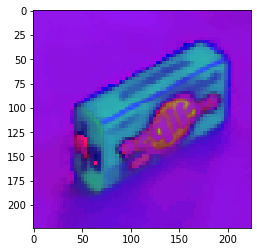

In [11]:
plt.imshow(hsv_img_train[0].astype(np.uint8))

In [12]:
def load_depthimages_from_folder(folder):
    images = []
    imgs = glob.glob(os.path.join(folder, '*d.png'))
    imgs.sort()
    for filename in imgs:
        im = image.load_img(filename, target_size=(224, 224))
        im = image.img_to_array(im)
        images.append(im)
    return images

images_depth_train = load_depthimages_from_folder(data_dir)

In [13]:
len(images_depth_train), images_depth_train[0].shape

(24, (224, 224, 3))

In [14]:
images_depth_train[0]

array([[[54., 54., 54.],
        [54., 54., 54.],
        [54., 54., 54.],
        ...,
        [54., 54., 54.],
        [54., 54., 54.],
        [54., 54., 54.]],

       [[54., 54., 54.],
        [54., 54., 54.],
        [54., 54., 54.],
        ...,
        [54., 54., 54.],
        [54., 54., 54.],
        [54., 54., 54.]],

       [[54., 54., 54.],
        [54., 54., 54.],
        [54., 54., 54.],
        ...,
        [54., 54., 54.],
        [54., 54., 54.],
        [54., 54., 54.]],

       ...,

       [[46., 46., 46.],
        [46., 46., 46.],
        [46., 46., 46.],
        ...,
        [46., 46., 46.],
        [46., 46., 46.],
        [46., 46., 46.]],

       [[46., 46., 46.],
        [46., 46., 46.],
        [46., 46., 46.],
        ...,
        [46., 46., 46.],
        [46., 46., 46.],
        [46., 46., 46.]],

       [[46., 46., 46.],
        [46., 46., 46.],
        [46., 46., 46.],
        ...,
        [46., 46., 46.],
        [46., 46., 46.],
        [46., 46., 46.]]

## Image Preprocessing

In [15]:
train_img = np.empty([24, 224, 224, 3], dtype = float)

train_img[:, :, :, 0:2] = np.array(hsv_img_train)[:, :, :, 0:2]
train_img[:, :, :, 2] = np.array(images_depth_train)[:, :, :, 1]

In [16]:
train_img[0]

array([[[145.71429443,  22.78723335,  54.        ],
        [145.71429443,  22.78723335,  54.        ],
        [145.71429443,  22.78723335,  54.        ],
        ...,
        [138.125     ,  14.29906368,  54.        ],
        [138.125     ,  14.36619568,  54.        ],
        [138.125     ,  14.36619568,  54.        ]],

       [[145.71429443,  22.78723335,  54.        ],
        [145.71429443,  22.78723335,  54.        ],
        [145.71429443,  22.78723335,  54.        ],
        ...,
        [138.125     ,  14.29906368,  54.        ],
        [138.125     ,  14.36619568,  54.        ],
        [138.125     ,  14.36619568,  54.        ]],

       [[145.71429443,  22.78723335,  54.        ],
        [145.71429443,  22.78723335,  54.        ],
        [145.71429443,  22.78723335,  54.        ],
        ...,
        [138.125     ,  14.36619568,  54.        ],
        [138.125     ,  14.36619568,  54.        ],
        [138.125     ,  14.36619568,  54.        ]],

       ...,

      

In [17]:
train_img.shape

(24, 224, 224, 3)

In [18]:
type(train_img)

numpy.ndarray

## First Training

In [19]:
model = load_model('my_model_f.h5')

In [20]:
model.compile(optimizer = Adam(lr = 0.001, decay = 1e-6), loss = 'mean_squared_error', metrics = ['acc'])

In [ ]:
model.fit(train_img, y_train, batch_size = 1, epochs = 30, verbose = 1)

In [ ]:
gggggggg

In [ ]:
model_all.save('my_model_fT.h5')

In [ ]:
model.save_weights('model_fT.h5')
model_json = model.to_json()
with open('model_fT.json', "w") as json_file:
    json_file.write(model_json)
json_file.close()